In [9]:
# General libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn libraries
from sklearn.model_selection import train_test_split

# Utils functions
from utils.utils import compare_models, plot_score_dist, compare_confidence_intervals, five_two, read_datasets

In [10]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [11]:
def load_model(model):
    models_folder = '../models/'
    return joblib.load(models_folder + model + '_model.joblib')

In [12]:
#1000 to 10.000 did not show significative differences
#size 2270 based on the paper: https://www.econstor.eu/bitstream/10419/67820/1/587473266.pdf
random_state_list = list(np.random.randint(low = 1,high=5000,size=2270))

## Linear Regression VS SVR

In [13]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.037759
Fold  2 score difference = -0.127961
Fold  1 score difference = -0.124009
Fold  2 score difference = -0.122886
Fold  1 score difference = -0.233174
Fold  2 score difference = -0.118433
Fold  1 score difference = -0.046859
Fold  2 score difference = -0.095336
Fold  1 score difference = -0.164989
Fold  2 score difference = -0.112361
Regression 1 mean score and stdev : 0.043219 + 0.073345
Regression 2 mean score and stdev : 0.161596 + 0.047055
Score difference mean + stdev : -0.118377 + 0.052608
t_value for the current test is -0.734564


mean_score_1 0.05847478671697645, std 0.10929528886983239
mean_score_2 0.21693424890806318, std 0.0990273199078994
Ttest_relResult(statistic=-87.83297288369594, pvalue=0.0)
P value menor ou igual a 0.05


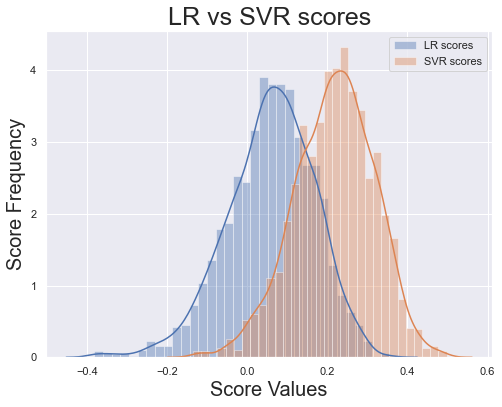

In [14]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)


plot_score_dist(reg1_scores, reg2_scores, 'LR', 'SVR')

In [15]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.176560807757439
0.2534624788186387
0.00952981135985326
0.39136491134367374


## Linear Regression VS XGBoost

In [16]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.014949
Fold  2 score difference = -0.083515
Fold  1 score difference = -0.112049
Fold  2 score difference = -0.076113
Fold  1 score difference = -0.143415
Fold  2 score difference = -0.080207
Fold  1 score difference = 0.007169
Fold  2 score difference = -0.079531
Fold  1 score difference = -0.064843
Fold  2 score difference = -0.007348
Regression 1 mean score and stdev : 0.043219 + 0.073345
Regression 2 mean score and stdev : 0.105709 + 0.044517
Score difference mean + stdev : -0.062490 + 0.049124
t_value for the current test is 0.294281


mean_score_1 0.05847478671697645, std 0.10929528886983239
mean_score_2 0.27692053531139205, std 0.07433279356964763
Ttest_relResult(statistic=-118.55198871485123, pvalue=0.0)
P value menor ou igual a 0.05


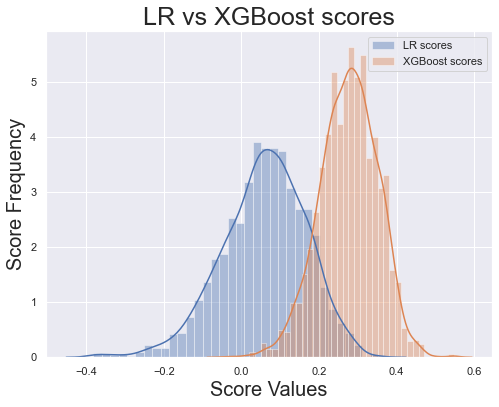

In [17]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'LR', 'XGBoost')

In [18]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.176560807757439
0.2534624788186387
0.12496055472628145
0.4080194166993631


## SVR VS XGboost

In [19]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.052708
Fold  2 score difference = 0.044446
Fold  1 score difference = 0.011960
Fold  2 score difference = 0.046773
Fold  1 score difference = 0.089759
Fold  2 score difference = 0.038226
Fold  1 score difference = 0.054028
Fold  2 score difference = 0.015805
Fold  1 score difference = 0.100146
Fold  2 score difference = 0.105013
Regression 1 mean score and stdev : 0.161596 + 0.047055
Regression 2 mean score and stdev : 0.105709 + 0.044517
Score difference mean + stdev : 0.055886 + 0.030976
t_value for the current test is 2.263887


mean_score_1 0.21693424890806318, std 0.0990273199078994
mean_score_2 0.27692053531139205, std 0.07433279356964763
Ttest_relResult(statistic=-35.85867786935788, pvalue=1.7087216191276836e-223)
P value menor ou igual a 0.05


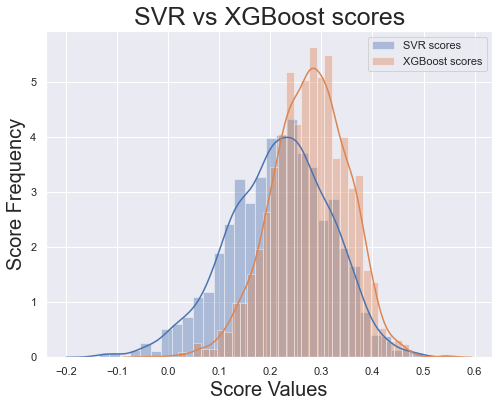

In [20]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [21]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

0.00952981135985326
0.39136491134367374
0.12496055472628145
0.4080194166993631


mean_score_1 -0.5088340082015369, std 0.19080873835912324
mean_score_2 -0.39325067586341533, std 0.14322660224395517
Ttest_relResult(statistic=-35.858677869357884, pvalue=1.7087216191276836e-223)
P value menor ou igual a 0.05


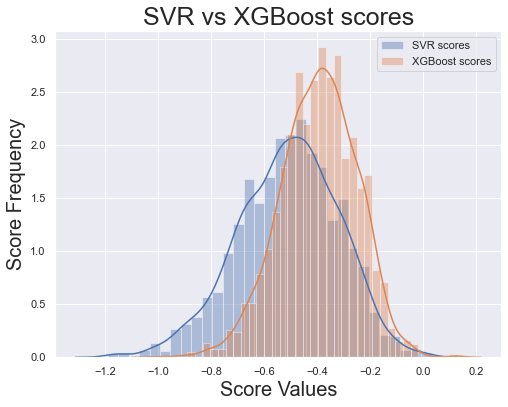

In [22]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    metric="adj_r2",
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [23]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.9084669488432094
-0.17273590253292137
-0.6860516140639943
-0.14064551416464185
